In [1]:
#Importing all the required python packages

import requests
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
from newspaper import Article
import datefinder
import datetime  
from htmldate import find_date
from textblob import TextBlob
from nltk.tokenize import word_tokenize 
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import urllib.request
from urllib.request import Request, urlopen
import validators

In [2]:
#These are the names of the columns in the UCI Online News Popularity Data Set with a few columns removed
#Link to dataset - https://archive.ics.uci.edu/ml/datasets/Online_News+Popularity#

COLUMN_NAMES = ['url',' n_tokens_title',' n_tokens_content',' n_unique_tokens', ' n_non_stop_words',' n_non_stop_unique_tokens',
                ' num_hrefs',' num_imgs', ' num_videos', ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
                ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech',
                ' data_channel_is_world', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
                ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend',
                ' global_subjectivity', ' global_sentiment_polarity', ' global_rate_positive_words', ' global_rate_negative_words',
                ' rate_positive_words', ' rate_negative_words', ' avg_positive_polarity', ' min_positive_polarity', ' max_positive_polarity',
                ' avg_negative_polarity', ' min_negative_polarity', ' max_negative_polarity', ' title_subjectivity',
                ' title_sentiment_polarity', ' abs_title_subjectivity', ' abs_title_sentiment_polarity']

In [3]:
#Checks if a URL id valid
def isValid(url):
    valid=validators.url(url)
    if valid==True:
        return 1
    else:
        return 0

In [22]:
#This web_crawler class crawls the webpage gathers the links and information to be fed into the predicting model .
#This is a single a single threaded web-crawler.
#It moves in a BFS fashion and uses a queue to gather links and crawl them.

#number_of_crawled_pages -> The number of pages after which you want the web-crawler to stop
class web_crawler:
    
    def __init__(self,base_url,number_of_crawled_pages):
        self.crawled = []
        self.queue = []
        self.queue.append(base_url)
        self.base_url = base_url
        self.number_of_crawled_pages = number_of_crawled_pages 
        
        
    #Establish connection with the page and make its soup
    def crawl_page(self,url):      
        
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        web_connect = urlopen(req)
        
        #If unable to connect to the website return an empty 
        if str(web_connect.getcode()) != "200":
            print("error connecting to the site! ")
            return []        
        
        html = web_connect.read()
        data = html.decode("utf8")        
        self.append_links_to_crawled(url)
        soup = BeautifulSoup(data,"html.parser")
        links = []
        
        
        #Crawler for times of india
        for link in soup.findAll('a',attrs = {'class':'w_img'}):
            l = str(link.get('href'))
            if l.startswith("http") and l not in links and l not in self.crawled and isValid(l):
                links.append(l)
            else:
                abs_link = str(urljoin(url, l)) 
                if abs_link not in links and abs_link not in self.crawled and isValid(abs_link):
                    links.append(abs_link)
        
        #uncomment this for Hindustan times crawler
        '''
        for link in soup.findAll('a'):
            #if link.has_attr('title'):
            l = str(link.get('href'))
            if (l.startswith("http")) and (l not in links) and (l not in self.crawled) and (isValid(l)) and (url in link):
                links.append(l)
            else:
                abs_link = str(urljoin(url+'/', l)) 
                if abs_link not in links and abs_link not in self.crawled and isValid(abs_link) and (url in abs_link):
                    links.append(abs_link)
        
       '''     
        
        return links,soup,web_connect
    
    
    def append_links_to_queue(self,links):
        self.queue = self.queue+links
        
    def append_links_to_crawled(self,link):
        self.crawled = self.crawled + [link] 
    
    
    #This function makes the spider start crawling and gather all the information from the website
    def crawl(self):
        df = pd.DataFrame(columns = COLUMN_NAMES)
        for i in range(self.number_of_crawled_pages):
            url = self.queue.pop(0)
            print("Link popped for crawling",url)            
            lnks,sp,wb_cnt = self.crawl_page(url)
            
            #Required info stored in "dic" dictionary
            dic = {}
            wb = webpage(url,sp,wb_cnt)
            dic["url"] = url
            dic[" n_tokens_title"] = wb.n_tokens_title_2()
            
            dic[" n_tokens_content"],dic[" n_unique_tokens"] = wb.n_tokens_content34()
            
            dic[" n_non_stop_words"], dic[" n_non_stop_unique_tokens"]= wb.n_non_stop_words56()
             
            dic[" num_hrefs"] = wb.num_hrefs7()
            
            dic[" num_imgs"] = wb.num_imgs9()
            
            dic[" num_videos"] = wb.num_videos10()
            
            dic[" average_token_length"] = wb.average_token_length11()
              
            dic[" num_keywords"] = wb.num_keywords12() 
            
            a,b,c,d,e,f= wb.data_channel1318()
            dic[" data_channel_is_lifestyle"] = a
            dic[" data_channel_is_entertainment"] = b 
            dic[" data_channel_is_bus"] = c
            dic[" data_channel_is_socmed"] = d
            dic[" data_channel_is_tech"] = e
            dic[" data_channel_is_world"] = f
            
            l,m,n,o,p,q,r,ss = wb.features3137()
            dic[" weekday_is_monday"] = l
            dic[" weekday_is_tuesday"] = m
            dic[" weekday_is_wednesday"] = n
            dic[" weekday_is_thursday"] = o
            dic[" weekday_is_friday"] = p
            dic[" weekday_is_saturday"] = q
            dic[" weekday_is_sunday"] = r
            dic[" is_weekend"] = ss
            
            s,t,u,v,w, x, y, z,g,h,i,j = wb.sub_pos4455()
            dic[" global_subjectivity"] = s
            dic[" global_sentiment_polarity"] = t
            dic[" global_rate_positive_words"] = u
            dic[" global_rate_negative_words"] = v
            dic[" rate_positive_words"] = w
            dic[" rate_negative_words"] = x
            dic[" avg_positive_polarity"] = y
            dic[" min_positive_polarity"] = z
            dic[" max_positive_polarity"] = g
            dic[" avg_negative_polarity"] = h
            dic[" min_negative_polarity"] = i
            dic[" max_negative_polarity"] = j
            
            j,k,dic[" abs_title_subjectivity"],dic[" abs_title_sentiment_polarity"] = wb.title_sub46()
            dic[" title_subjectivity"] = j
            dic[" title_sentiment_polarity"] = k  
            
            self.append_links_to_queue(lnks)
            
            
            df = df.append(dic, ignore_index = True)  
            
            
        
        print("The links in the queue after crawling are: ",len(self.queue))
        print()
        print("The links crawled are",len(self.crawled))
        #Datframe of all the websites' info that the spider has crawled
        return df
    

In [5]:

#This class has methods to extract all the features of the webpage required by the model

class webpage:
    def __init__(self,url,soup, web_connect):
        self.url = url
        self.web_connect = web_connect
        
        #if unable to connect return
        if str(self.web_connect.getcode()) != "200":
            print("error connecting to the site! ")
            return
        data = (self.web_connect.read())
        
        self.soup = soup
        self.article = Article(url,"en")
        
    
    #returns length of the title
    def n_tokens_title_2(self):
        if self.soup.title==None:
            return 0
        return (len(self.soup.title.string.split()))
        
    #returns the number of words and number of unique words from the content
    def n_tokens_content34(self):
        words = []        
        unique_words = set()             

        for i in self.soup.findAll("p"): 
            words = words + i.text.split(' ')
            for word in i.text.split(' '):
                unique_words.add(word)             
        
        #in case needed again
        self.words = words
        self.unique_words = unique_words
        
        if len(words)==0:
            self.words.append(".")
            self.unique_words.add(".")
        
        return len(words), (len(unique_words)/len(words))
    
    #rates of non-stop_words and unique non-stop_words
    def n_non_stop_words56(self):
        stop_words = set(stopwords.words('english'))
        unique_non_stop_words = set()        
        non_stop_words = 0
        for word in self.words:
            if word not in stop_words:
                non_stop_words += 1
                unique_non_stop_words.add(word)
        
        return non_stop_words/len(self.words),len(unique_non_stop_words)/len(self.words)
    
    #Number of links in the content of webpage
    def num_hrefs7(self):
        text_links = []
        for paragraph in self.soup.find_all("p"):
            for a in paragraph("a"):
                text_links.append(a.get('href'))
        return len(text_links)
    
    #Number of images in the webpage
    def num_imgs9(self):
        num = 0
        for image in self.soup.find_all("img"):
            num+=1
        return num
    
    #Number of videos in the webpage
    def num_videos10(self):
        return len(self.article.movies)
    
    #Average length of word in content
    def average_token_length11(self):
        total_len = 0
        for word in self.words:
            total_len += len(word)
        return (total_len)/len(self.words)
        
    #Number of keywords in the website   
    def num_keywords12(self):
        keywords = ""
        for i in self.soup.findAll("meta"):    
            if i.has_attr('name') and i.has_attr('content') :
                if '''name="keywords"''' in str(i):
                    keywords = str(i['content'])
                    break
        self.key_words = keywords.split(",")
        return len(self.key_words)
    
    #Determines the type of website it is
    def data_channel1318(self):
        poss = {"lifestyle":0,"entertainment":0,"bus":0,"socmed":0,"tech":0,"world":0}
        
        lf = ["lifestyle","fashion","healthy","gardening", "exercise","gym","yoga","wealthy","unhealthy"]
        en = ["entertainment","amusement","games","fun","play","amazon-prime","Netflix"]
        so = ["facebook", "twitter", "instagram","snapchat","whatsapp","linkedIn"]
        te = ["tech","technology","mobile","laptop"]
        bus = ["business","coperate","retargeting","customer"]
        wo = ["world","counties","country"]
        
        #First check from the keywords
        for word in poss:
            for key in self.key_words:
                if word in key:
                    poss[word]=1
                    
        
        #Now look into the content
        for word in self.words:
            if word in lf:
                poss["lifestyle"] = 1
            if word in en:
                poss["entertainment"] = 1
            if word in bus:
                poss["bus"] = 1
            if word in so:
                poss["socmed"] = 1
            if word in te:
                poss["tech"] = 1
            if word in wo:
                poss["world"] = 1
        
        return poss["lifestyle"],poss["entertainment"],poss["bus"],poss["socmed"],poss["tech"],poss["world"]
            
    #Determines Which day it was published    
    def features3137(self):        
        date = find_date(self.url)
        if(date==None):
            return 1,0,0,0,0,0,0,0
        year, month, day = date.split('-')
        day = datetime.date(int(year), int(month), int(day))
        dayy = str(day.strftime("%A"))
        if dayy=="Monday":
            return 1,0,0,0,0,0,0,0
        if dayy=="Tuesday":
            return 0,1,0,0,0,0,0,0
        if dayy=="Wednesday":
            return 0,0,1,0,0,0,0,0
        if dayy=="Thursday":
            return 0,0,0,1,0,0,0,0
        if dayy=="Friday":
            return 0,0,0,0,1,0,0,0
        if dayy=="Saturday":
            return 0,0,0,0,0,1,0,1
        if dayy=="Sunday":
            return 0,0,0,0,0,0,1,0
        
    #Gives content related to the polarity and subjectivity of the content 
    def sub_pos4455(self):       
        full_art = ""
        pos_words = []
        avg_pos = avg_neg = 0
        pos_polarity = []
        neg_polarity = []
        
        neg_words = []
        neutral = []
        for word in self.words: 
            full_art +=(word+" ") 

            analysis = TextBlob(word)
            p1,_ = analysis.sentiment 
            if p1>0:
                pos_words.append(word)
                avg_pos+=p1
                pos_polarity.append(p1)
            elif p1<0:
                neg_words.append(word)
                avg_neg+=p1
                neg_polarity.append(p1)
            else:
                neutral.append(word)
        analysis = TextBlob(full_art)
        p,s = analysis.sentiment
        
        pos_posneg = 0 if(len(pos_words)+len(neg_words)==0) else (len(pos_words)/(len(pos_words)+len(neg_words)))
        neg_posneg = 0 if (len(pos_words)+len(neg_words)==0) else (len(neg_words)/(len(pos_words)+len(neg_words)))
        
        avg_neg = 0 if (len(neg_words)==0) else avg_neg/len(neg_words)
        avg_pos = 0 if (len(pos_words)==0) else avg_pos/len(pos_words)
        
        min_pos = min(pos_polarity) if(len(pos_words)>0) else 0 
        max_pos = max(pos_polarity) if(len(pos_words)>0) else 0 
        min_neg = min(neg_polarity) if(len(neg_words)>0) else 0 
        max_neg = max(neg_polarity) if(len(neg_words)>0) else 0 
        
        return float(s),float(p),len(pos_words)/len(self.words),len(neg_words)/len(self.words),pos_posneg,neg_posneg,avg_pos,min_pos,max_pos,avg_neg,min_neg,max_neg

    #title sentiment and subjectivity
    def title_sub46(self):  
        if(self.soup.title==None):
            return 0,0,0,0
        analysis = TextBlob(self.soup.title.string)
        p,s = analysis.sentiment
        return float(s),float(p),abs(s),abs(p)
      
        

In [6]:
#Training a Random Forest Classfier on the UCI Online News Popularity Data Set

In [7]:
#Okay so now I am finally trainning a Random Forest Classifier
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor as rg
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(r'C:\Users\Parul\Desktop\Viral_detection\UCI\UCI_Dat.csv')


In [8]:
#Shuffle the dataset for better predictions
df = df.sample(frac = 1)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
25768,http://mashable.com/2014/05/23/wolfenstein-the...,229.0,9.0,185.0,0.672414,1.0,0.729508,11.0,2.0,10.0,...,0.062500,1.000000,-0.441667,-0.70,-0.291667,0.000000,0.000000,0.500000,0.000000,4100
11368,http://mashable.com/2013/08/12/real-mona-lisa-...,514.0,10.0,307.0,0.651877,1.0,0.677570,13.0,4.0,1.0,...,0.033333,1.000000,-0.231845,-0.75,-0.071429,0.000000,0.000000,0.500000,0.000000,3100
6976,http://mashable.com/2013/05/16/japanese-human-...,602.0,10.0,260.0,0.586345,1.0,0.628272,22.0,4.0,7.0,...,0.100000,0.166667,-0.327778,-0.50,-0.155556,0.129630,-0.051852,0.370370,0.051852,995
35195,http://mashable.com/2014/10/21/montreal-teacher/,78.0,11.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00,0.000000,0.650000,0.350000,0.150000,0.350000,5100
19581,http://mashable.com/2014/01/29/samsung-smart-d...,344.0,11.0,537.0,0.560636,1.0,0.690476,29.0,8.0,1.0,...,0.100000,0.500000,-0.219775,-0.60,-0.071429,0.366667,0.175000,0.133333,0.175000,2000


In [9]:
X = df.drop(columns = ['url',' timedelta',' num_self_hrefs',' kw_min_min',' kw_max_min'
                      ,' kw_avg_min',' kw_min_max',' kw_max_max',' kw_avg_max',' kw_min_avg'
                      ,' kw_max_avg',' kw_avg_avg',' self_reference_min_shares',' self_reference_max_shares',' self_reference_avg_sharess'
                      ,' LDA_00',' LDA_01',' LDA_02',' LDA_03',' LDA_04',' shares'])
Y = df[' shares']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=13)
X.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
25768,9.0,185.0,0.672414,1.0,0.729508,11.0,10.0,0.0,4.816216,9.0,...,0.414773,0.062500,1.000000,-0.441667,-0.70,-0.291667,0.000000,0.000000,0.500000,0.000000
11368,10.0,307.0,0.651877,1.0,0.677570,13.0,1.0,2.0,4.925081,6.0,...,0.436448,0.033333,1.000000,-0.231845,-0.75,-0.071429,0.000000,0.000000,0.500000,0.000000
6976,10.0,260.0,0.586345,1.0,0.628272,22.0,7.0,0.0,5.315385,7.0,...,0.144444,0.100000,0.166667,-0.327778,-0.50,-0.155556,0.129630,-0.051852,0.370370,0.051852
35195,11.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.650000,0.350000,0.150000,0.350000
19581,11.0,537.0,0.560636,1.0,0.690476,29.0,1.0,21.0,4.744879,7.0,...,0.257086,0.100000,0.500000,-0.219775,-0.60,-0.071429,0.366667,0.175000,0.133333,0.175000


In [10]:
model = rg(random_state=13)
model.fit(X_train,y_train)

C:\Users\Parul\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

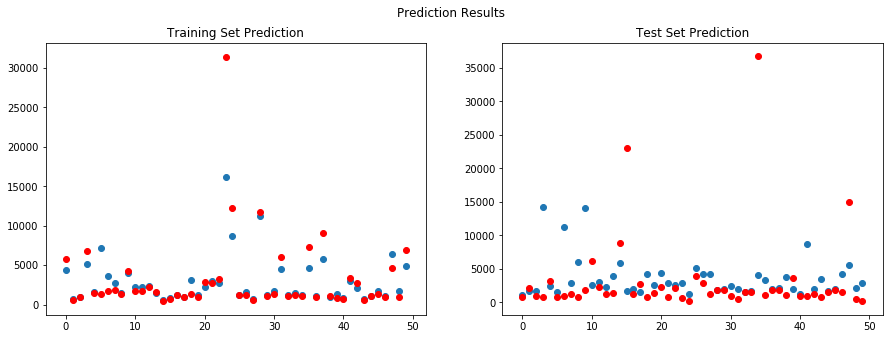

In [11]:
y_train_pred = model.predict(X_train).transpose()
y_test_pred = model.predict(X_test).transpose()

fig, (axs1,axs2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Prediction Results')

axs1.set_title('Training Set Prediction')
axs1.scatter([i for i in range(50)],y_train_pred[:50])
axs1.scatter([i for i in range(50)],y_train[:50],c='red')

axs2.set_title('Test Set Prediction')
axs2.scatter([i for i in range(50)],y_test_pred[:50])
axs2.scatter([i for i in range(50)],y_test[:50],c='red')

plt.show()

In [12]:
BASE_URL2 = "https://www.hindustantimes.com/"
BASE_URL = "https://timesofindia.indiatimes.com/"
crawler = web_crawler(BASE_URL,10)
dtf = crawler.crawl()

Link popped for crawling https://timesofindia.indiatimes.com/
Link popped for crawling https://timesofindia.indiatimes.com/india/irs-officers-suggest-higher-tax-on-rich-covid-19-cess-to-boost-revenue/articleshow/75388928.cms
Link popped for crawling https://www.gadgetsnow.com/slideshows/17-data-plans-from-airtel-vodafone-idea-and-reliance-jio-that-offer-2gb/3gb-data-per-day/17-data-plans-from-Airtel-Vodafone-Idea-and-Reliance-Jio-that-offer-2GB/3GB-data-per-day/photolist/75382733.cms?utm_source=toiweb&utm_medium=referral&utm_campaign=toiweb_hpwidget
Link popped for crawling https://www.gadgetsnow.com/reviews/samsung-galaxy-m31/articleshow/72510517.cms?utm_source=toiweb&utm_medium=referral&utm_campaign=toiweb_hpwidget
Link popped for crawling https://timesofindia.indiatimes.com/life-style/health-fitness/health-news/the-fear-of-coronavirus-and-flu-colliding-in-the-fall/articleshow/75313413.cms
Link popped for crawling https://timesofindia.indiatimes.com/life-style/health-fitness/health-n

In [13]:
dtf

,url,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,https://timesofindia.indiatimes.com/,19,95,0.905263,0.894737,0.831579,1,145,0,5.294737,...,0.318182,0.136364,0.500000,-0.150000,-0.15,-0.150000,0.500000,0.250000,0.500000,0.250000
1,https://timesofindia.indiatimes.com/india/irs-...,19,39,0.820513,0.897436,0.743590,3,12,0,5.025641,...,0.500000,0.500000,0.500000,0.000000,0.00,0.000000,0.625000,0.312500,0.625000,0.312500
2,https://www.gadgetsnow.com/slideshows/17-data-...,18,69,0.840580,0.695652,0.637681,0,30,0,5.304348,...,0.166667,0.166667,0.166667,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,https://www.gadgetsnow.com/reviews/samsung-gal...,13,11,1.000000,0.909091,0.909091,0,43,0,5.818182,...,0.700000,0.700000,0.700000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,https://timesofindia.indiatimes.com/life-style...,14,1036,0.565637,0.684363,0.500965,0,109,0,4.806950,...,0.424226,0.062500,1.000000,-0.303009,-0.70,-0.100000,0.000000,0.000000,0.000000,0.000000
5,https://timesofindia.indiatimes.com/life-style...,13,1009,0.569871,0.685828,0.503469,0,109,0,4.854311,...,0.424226,0.062500,1.000000,-0.303009,-0.70,-0.100000,0.066667,0.033333,0.066667,0.033333
6,https://timesofindia.indiatimes.com/life-style...,13,1012,0.572134,0.686759,0.505929,0,109,0,4.841897,...,0.424226,0.062500,1.000000,-0.303009,-0.70,-0.100000,0.700000,0.425000,0.700000,0.425000
7,https://timesofindia.indiatimes.com/life-style...,12,1029,0.564626,0.686103,0.499514,0,109,0,4.809524,...,0.445734,0.062500,1.000000,-0.256978,-0.70,-0.071429,0.000000,0.000000,0.000000,0.000000
8,https://timesofindia.indiatimes.com/life-style...,12,1019,0.567223,0.684004,0.501472,0,109,0,4.837095,...,0.445734,0.062500,1.000000,-0.256978,-0.70,-0.071429,1.000000,0.800000,1.000000,0.800000
9,https://timesofindia.indiatimes.com/toisa/tois...,9,36,0.916667,0.944444,0.861111,1,28,0,5.138889,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
dtf_n = dtf.drop(columns= ["url"])
dtf_n = dtf_n.fillna(0)
dtf_n.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,19,95,0.905263,0.894737,0.831579,1,145,0,5.294737,12,...,0.318182,0.136364,0.500000,-0.150000,-0.15,-0.15,0.500,0.2500,0.500,0.2500
1,19,39,0.820513,0.897436,0.743590,3,12,0,5.025641,13,...,0.500000,0.500000,0.500000,0.000000,0.00,0.00,0.625,0.3125,0.625,0.3125
2,18,69,0.840580,0.695652,0.637681,0,30,0,5.304348,1,...,0.166667,0.166667,0.166667,0.000000,0.00,0.00,0.000,0.0000,0.000,0.0000
3,13,11,1.000000,0.909091,0.909091,0,43,0,5.818182,6,...,0.700000,0.700000,0.700000,0.000000,0.00,0.00,0.000,0.0000,0.000,0.0000
4,14,1036,0.565637,0.684363,0.500965,0,109,0,4.806950,6,...,0.424226,0.062500,1.000000,-0.303009,-0.70,-0.10,0.000,0.0000,0.000,0.0000


In [20]:
prediction_n = model.predict(dtf_n).transpose()

results = {"url" : list(dtf['url']),"prediction": prediction_n}
result_df =pd.DataFrame(results)
result_df

,url,prediction
0,https://timesofindia.indiatimes.com/,12829.2
1,https://timesofindia.indiatimes.com/india/irs-...,12740.0
2,https://www.gadgetsnow.com/slideshows/17-data-...,9172.6
3,https://www.gadgetsnow.com/reviews/samsung-gal...,15773.4
4,https://timesofindia.indiatimes.com/life-style...,15648.6
5,https://timesofindia.indiatimes.com/life-style...,14798.6
6,https://timesofindia.indiatimes.com/life-style...,17429.4
7,https://timesofindia.indiatimes.com/life-style...,17380.0
8,https://timesofindia.indiatimes.com/life-style...,17540.0
9,https://timesofindia.indiatimes.com/toisa/tois...,11200.0


In [21]:
#If we keep the threshold as 17000 
#Assumption - No. of shares is directly proportional to prob. of article getting viralled
result_df['prediction'] = result_df['prediction'].apply(lambda x: "Yes" if x>17000 else "No")
result_df

,url,prediction
0,https://timesofindia.indiatimes.com/,No
1,https://timesofindia.indiatimes.com/india/irs-...,No
2,https://www.gadgetsnow.com/slideshows/17-data-...,No
3,https://www.gadgetsnow.com/reviews/samsung-gal...,No
4,https://timesofindia.indiatimes.com/life-style...,No
5,https://timesofindia.indiatimes.com/life-style...,No
6,https://timesofindia.indiatimes.com/life-style...,Yes
7,https://timesofindia.indiatimes.com/life-style...,Yes
8,https://timesofindia.indiatimes.com/life-style...,Yes
9,https://timesofindia.indiatimes.com/toisa/tois...,No


In [23]:
#uncomment the portion in the webcrawler class to modify it a bit to crawl to hindustan times
BASE_URL2 = "https://www.hindustantimes.com/india-news/"
crawler2 = web_crawler(BASE_URL2,5)
dtf2 = crawler2.crawl()

Link popped for crawling https://www.hindustantimes.com/india-news/
Link popped for crawling https://www.hindustantimes.com/india-news/covid-19-lockdown-376-students-from-jammu-and-kashmir-ladakh-stranded-in-rajasthan-s-kota-depart-for-home/story-esNcLnGoNhdUyJrpSexfqL.html
Link popped for crawling https://www.hindustantimes.com/india-news/100-tonne-medicine-payments-worth-rs-452-crore-how-india-post-served-covid-19-hit-country/story-Y5jNWOPGDGNDti2wjOex4I.html
Link popped for crawling https://www.hindustantimes.com/india-news/am-alive-says-mp-covid-19-patient-in-video-after-being-declared-dead-by-doctor/story-G2UEEjzd4NNSwiKZDl2LTN.html
Link popped for crawling https://www.hindustantimes.com/india-news/on-akshay-tritiya-pm-modi-calls-on-people-to-help-each-other-amid-covid-19/story-WMJxRo5fvyZu7RD05vyJjK.html
The links in the queue after crawling are:  38

The links crawled are 5


In [24]:
dtf2.head()



,url,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,https://www.hindustantimes.com/india-news/,12,424,0.613208,0.613208,0.507075,0,41,0,5.205189,...,0.356818,0.200000,0.5,-0.200000,-0.500,-0.125,0.500,0.136364,0.500,0.136364
1,https://www.hindustantimes.com/india-news/covi...,22,282,0.687943,0.687943,0.574468,20,33,0,5.606383,...,0.383333,0.100000,0.8,-0.185000,-0.300,-0.125,0.000,0.000000,0.000,0.000000
2,https://www.hindustantimes.com/india-news/100-...,20,314,0.662420,0.700637,0.557325,16,33,0,5.579618,...,0.320000,0.100000,0.5,-0.125000,-0.125,-0.125,0.100,0.300000,0.100,0.300000
3,https://www.hindustantimes.com/india-news/am-a...,20,447,0.541387,0.651007,0.458613,16,33,0,4.961969,...,0.254167,0.033333,0.7,-0.264583,-1.000,-0.100,0.400,-0.050000,0.400,0.050000
4,https://www.hindustantimes.com/india-news/on-a...,20,430,0.576744,0.646512,0.469767,18,33,0,4.909302,...,0.354713,0.136364,0.5,-0.240278,-0.400,-0.050,0.375,-0.125000,0.375,0.125000
